# Topical Expert Model

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import os
print(os.getcwd())
print(os.listdir('/Users/Brandon/Yelp Dataset/dataset'))
import json
import glob
from datetime import datetime
from pandas import HDFStore,DataFrame
import operator
import pylab as pl

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib

/Users/Brandon/Yelp Dataset/Yelp-FA17/local-elites/brandon
['.DS_Store', 'business.json', 'checkin.json', 'photos.json', 'review.json', 'review5000.json', 'tip.json', 'user.json', 'user5000.json']


In [2]:
#Copied from Kenta
def load_json_to_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

LOAD THE DATA

In [3]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/review.json"
review = load_json_to_df(import_file)

CPU times: user 1min 15s, sys: 19.7 s, total: 1min 35s
Wall time: 2min 9s


In [4]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/business.json"
business = load_json_to_df(import_file)

CPU times: user 5.26 s, sys: 276 ms, total: 5.53 s
Wall time: 5.64 s


In [5]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/user.json"
user = load_json_to_df(import_file)

CPU times: user 55.2 s, sys: 14.7 s, total: 1min 9s
Wall time: 1min 21s


Sort by category

In [6]:
def categoryFind(df, cat):
    return [cat in i for i in df['categories']]

def category_counts(df):
    all_cats = []
    for i in df['categories']:
        for j in i:
            all_cats.append(j)
    categories = set(all_cats)
    category_counts = {}
    for cat in categories:
        category_counts[cat] = all_cats.count(cat)
    return len(categories), category_counts

def top_categories(counts, n):
    top_categories = sorted(counts.keys(), key=(lambda k: counts[k]),reverse=True)[:n]
    return top_categories

In [7]:
num_cats, cat_counts = category_counts(business)
top_cats = top_categories(cat_counts, 15)
display(top_cats)

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food']

In [8]:
%%time
businessReviews = pd.merge(review, business,on='business_id',right_index=True,sort=False)[['business_id', 'cool', 'funny', 'review_id', 'stars_x', 'text', 'useful', 'user_id', 'categories', 'review_count', 'stars_y']]
bus_rev_users = pd.merge(businessReviews, user,on='user_id',right_index=True,sort=False)[['business_id', 'cool_x', 'funny_x', 'review_id', 'stars_x', 'text', 'useful_x', 'user_id', 'categories', 'stars_y', 'average_stars', 'cool_y', 'elite', 'fans', 'friends', 'name', 'review_count_y', 'yelping_since']]

CPU times: user 1min 1s, sys: 29.7 s, total: 1min 31s
Wall time: 1min 58s


In [9]:
display(len(businessReviews))
display(len(bus_rev_users))
display(list(businessReviews))
display(list(bus_rev_users))

4736897

4736897

['business_id',
 'cool',
 'funny',
 'review_id',
 'stars_x',
 'text',
 'useful',
 'user_id',
 'categories',
 'review_count',
 'stars_y']

['business_id',
 'cool_x',
 'funny_x',
 'review_id',
 'stars_x',
 'text',
 'useful_x',
 'user_id',
 'categories',
 'stars_y',
 'average_stars',
 'cool_y',
 'elite',
 'fans',
 'friends',
 'name',
 'review_count_y',
 'yelping_since']

## Feature Extraction From Yelp Data

In [10]:
def category_choose(df, categories):
    cats = np.array([True] * len(df['categories']))
    for cat in categories:
        cats= cats & np.array(categoryFind(df,cat))
    return df[cats]

def numCategoryReviews(businessReviews):
    return businessReviews[['business_id','user_id']].groupby('user_id',as_index=False).count()

def average_star_category_rating(businessReviews):
    return businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).mean()

def std_star_category_rating(businessReviews):
    busRev = businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).agg(np.var)
    busRev['stars_x'] = busRev['stars_x'].pow(1./2)
    return busRev

def funny_useful_cool(businessReviews):
    return businessReviews[['user_id','funny','useful','cool']].groupby('user_id',as_index=False).sum()

def months_yelping(businessReviews):
    user_dates = businessReviews[['user_id','yelping_since']].drop_duplicates()
    curr_date = datetime(2017,10,17)
    uyelp_dates = [datetime.strptime(i, "%Y-%m-%d") for i in user_dates['yelping_since']]
    months_yelping = [(curr_date.year - i.year) * 12 + curr_date.month - i.month for i in uyelp_dates]
    user_dates['yelping_since'] = months_yelping
    return user_dates

def get_elite_users(df):
    temp = []
    for i in df['elite'].index.values:
        if df['elite'][i]:
            temp.append(i)
    return temp, df.loc[temp]

## Define the first feature model to be analyzed
Features: Total Reviews by User, Number of Category Reviews, Average Rating in Category, Std Dev of Ratings in Category, Funny, Useful, and Cool Votes, Number of Months since joining Yelp.

In [11]:
def feature1(df, df1, categories):
    if( not categories == "All"):
        df = category_choose(df, categories)
        df1 = category_choose(df1, categories)
    tot_reviews = df1[['user_id','review_count_y']]
    tot_reviews.columns = ['user_id','Total Reviews by User']
    catRev = numCategoryReviews(df)
    catRev.columns = ['user_id','Num Category Reviews']
    averageCat = average_star_category_rating(df)
    averageCat.columns = ['user_id','Average Rating in Category']
    stdCat = std_star_category_rating(df)
    stdCat.columns = ['user_id','Std Dev of Ratings in Category']
    fuc = funny_useful_cool(df)
    monthsYelp = months_yelping(df1)
    monthsYelp.columns = ['user_id', 'Months Yelping']
    is_elite = df1[['user_id','elite']]
    features = tot_reviews.merge(catRev,on='user_id').merge(averageCat,on='user_id').merge(stdCat,on='user_id').merge(fuc,on='user_id').merge(monthsYelp,on='user_id').merge(is_elite,on='user_id')
    features = features.drop_duplicates('user_id')
    features.index = range(len(features))
    elite_ind, elite_users = get_elite_users(features)
    expertClassifier = [0]*len(features)
    for i in elite_ind:
        expertClassifier[i]=1
    features = pd.concat([features, pd.DataFrame(expertClassifier,columns=['is_expert'])],axis=1)
    return features.fillna(0)

# Feature 2 has all of feature 1 plus the number of friends for each user
def feature2(df, df1, categories, features1 = pd.DataFrame()):
    if features1.empty:
        features1= feature1(df,df1,categories)
    
    friends = pd.DataFrame([len(i) for i in df1['friends']], columns = ['Num_Friends'])
    users = pd.DataFrame(df1['user_id'].values,columns=['user_id'])
    num_friends = pd.concat([users, friends],axis=1)
    features1= features1.merge(num_friends,on='user_id').drop_duplicates('user_id')
    features1.index = range(len(features1))
    return features1
    

In [12]:
%%time
# Lets do places with categories Chinese Restaurant
categories = ['Restaurants','Chinese']
feature_set_1 = feature1(businessReviews, bus_rev_users, categories)

CPU times: user 14.6 s, sys: 7.97 s, total: 22.6 s
Wall time: 26.6 s


In [13]:
feature_set_2 = feature2(businessReviews, bus_rev_users, categories, feature_set_1)
feature_set_2

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert,Num_Friends
0,zXnH6W74FAJQ7q7b-NuBsA,90,1,4.000000,0.000000,0,0,0,87,[],0,26
1,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,2,0,68,"[2013, 2014]",1,15
2,kzyLOqiJvyw_FWFTw2rjiQ,2,1,1.000000,0.000000,0,0,0,16,[],0,0
3,WZXp9-V2dqRRJqhGgRqueA,327,4,2.500000,1.000000,4,6,4,61,"[2016, 2015]",1,181
4,XylT12exfdLiI_3uDLVIpw,344,1,5.000000,0.000000,1,2,1,84,[],0,762
5,Ji9PeffxjwqPLO7pEfSpKQ,93,6,2.500000,1.048809,6,9,7,107,"[2010, 2009]",1,53
6,TLIWzAJPrET0zX4_vgvLhg,53,1,3.000000,0.000000,0,0,0,38,[],0,19
7,JZEiTNWBwmv6MOOXYCAaMQ,5,2,1.000000,0.000000,0,0,0,29,[],0,0
8,E56sVQT5-OWfSejJrma8_w,13,1,5.000000,0.000000,1,1,1,68,[],0,19
9,4WYICo4emecA9r7sPYQkBw,15,1,4.000000,0.000000,0,0,0,99,[],0,0


In [14]:
display(len(feature_set_1))
display(feature_set_1.head(5))

109685

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert
0,zXnH6W74FAJQ7q7b-NuBsA,90,1,4.0,0.0,0,0,0,87,[],0
1,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.0,0.0,0,2,0,68,"[2013, 2014]",1
2,kzyLOqiJvyw_FWFTw2rjiQ,2,1,1.0,0.0,0,0,0,16,[],0
3,WZXp9-V2dqRRJqhGgRqueA,327,4,2.5,1.0,4,6,4,61,"[2016, 2015]",1
4,XylT12exfdLiI_3uDLVIpw,344,1,5.0,0.0,1,2,1,84,[],0


## Classifier Setups (Sklearn Library)*

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

In [16]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives the classifications'''
def run_model(clf, features):
    train, test = train_test_split(X)
    train_classifier = train['is_expert'].values
    test_classifier = test['is_expert'].values
    train = train.drop('is_expert',axis=1)
    test = test.drop('is_expert', axis=1)
    clf.fit(train, train_classifier)
    rf_pred = clf.predict(test)
    model_perf= {'Model_Score' : clf.score(test, test_classifier),
                'Predictions' : rf_pred,
                'Actual' : test_classifier,
                'Prediction_Probabilities' : clf.predict_proba(test),
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Experts_Actual' : sum(test_classifier),
                'Num_Experts_Training' : sum(train_classifier)} 
    return model_perf

'''Runs the model n times, and prints out a dictionary with the statistics'''
def bootstrap_model(clf, features, n):
    models = []
    for i in range(1,n):
        models.append(run_model(clf, features))
    return models

'''Gets statistics from the bootstrap list of dictionaries'''
def boot_statistics(models):
    stats = []
    mean_model_score = np.mean([i['Model_Score'] for i in models])
    expert_pred_percentage = [i['Num_Experts_Predicted']/i['Num_Experts_Actual'] for i in models]
    mn = np.array((1.0 - np.array(mean_model_score))) * np.array(models[0]['Total_Tested'])
    stats = {'Mean_Wrong_Predictions' : round(mn),
             'Mean_Model_Score' : mean_model_score, 
             'Expert_Prediction_Percentage' : expert_pred_percentage}
    return stats

def graph_from_statistics(stats):
    return 0

 #### Drop unnessary columns from the features table (call it X).

In [17]:
X = feature_set_1.drop('user_id',axis=1).drop('elite',axis=1)
X2 = feature_set_2.drop('user_id',axis=1).drop('elite',axis=1)

## Run a random forest classifier

In [18]:
clf_RF = RandomForestClassifier(max_depth=3)

display(run_model(clf_RF,X))
display(run_model(clf_RF,X2))

RF_bootstrap = bootstrap_model(clf_RF, X, 10)
RF2_bootstrap = bootstrap_model(clf_RF, X2, 10)

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.90307052731383564,
 'Num_Experts_Actual': 3587,
 'Num_Experts_Predicted': 1405,
 'Num_Experts_Training': 10783,
 'Prediction_Probabilities': array([[ 0.96278754,  0.03721246],
        [ 0.95662794,  0.04337206],
        [ 0.63285925,  0.36714075],
        ..., 
        [ 0.57730816,  0.42269184],
        [ 0.95662794,  0.04337206],
        [ 0.95662794,  0.04337206]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 27422}

{'Actual': array([0, 0, 0, ..., 0, 1, 1]),
 'Model_Score': 0.90390926992925391,
 'Num_Experts_Actual': 3654,
 'Num_Experts_Predicted': 1593,
 'Num_Experts_Training': 10716,
 'Prediction_Probabilities': array([[ 0.85145582,  0.14854418],
        [ 0.89755971,  0.10244029],
        [ 0.95128055,  0.04871945],
        ..., 
        [ 0.25369193,  0.74630807],
        [ 0.1815344 ,  0.8184656 ],
        [ 0.5164439 ,  0.4835561 ]]),
 'Predictions': array([0, 0, 0, ..., 1, 1, 0]),
 'Total_Tested': 27422}

## Run a gaussian naive bayes classifier

In [19]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()

display(run_model(clf_NB,X))
display(run_model(clf_NB,X2))

NB_bootstrap = bootstrap_model(clf_NB, X, 10)
NB2_bootstrap = bootstrap_model(clf_NB, X2, 10)

{'Actual': array([0, 1, 0, ..., 0, 0, 1]),
 'Model_Score': 0.90792064765516733,
 'Num_Experts_Actual': 3552,
 'Num_Experts_Predicted': 2017,
 'Num_Experts_Training': 10818,
 'Prediction_Probabilities': array([[  9.99999454e-01,   5.45846753e-07],
        [  0.00000000e+00,   1.00000000e+00],
        [  9.99350204e-01,   6.49795979e-04],
        ..., 
        [  9.99999404e-01,   5.95862417e-07],
        [  9.99999950e-01,   4.98197926e-08],
        [  2.96859259e-04,   9.99703141e-01]]),
 'Predictions': array([0, 1, 0, ..., 0, 0, 1]),
 'Total_Tested': 27422}

{'Actual': array([0, 0, 0, ..., 0, 0, 1]),
 'Model_Score': 0.90792064765516733,
 'Num_Experts_Actual': 3660,
 'Num_Experts_Predicted': 2209,
 'Num_Experts_Training': 10710,
 'Prediction_Probabilities': array([[  9.99998810e-01,   1.19042370e-06],
        [  9.99999200e-01,   8.00118298e-07],
        [  9.99999091e-01,   9.09089708e-07],
        ..., 
        [  9.99997647e-01,   2.35254204e-06],
        [  9.99999562e-01,   4.37526056e-07],
        [  1.82204650e-14,   1.00000000e+00]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 1]),
 'Total_Tested': 27422}

## Run a decision tree classifier

In [20]:
clf_DT = tree.DecisionTreeClassifier()

display(run_model(clf_DT, X))
display(run_model(clf_DT, X2))

DT_bootstrap = bootstrap_model(clf_DT, X, 10)
DT2_bootstrap = bootstrap_model(clf_DT, X2, 10)

{'Actual': array([0, 0, 0, ..., 1, 0, 0]),
 'Model_Score': 0.90445627598278755,
 'Num_Experts_Actual': 3584,
 'Num_Experts_Predicted': 3522,
 'Num_Experts_Training': 10786,
 'Prediction_Probabilities': array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.]]),
 'Predictions': array([0, 0, 0, ..., 1, 0, 0]),
 'Total_Tested': 27422}

{'Actual': array([1, 1, 0, ..., 1, 0, 0]),
 'Model_Score': 0.90299759317336448,
 'Num_Experts_Actual': 3659,
 'Num_Experts_Predicted': 3597,
 'Num_Experts_Training': 10711,
 'Prediction_Probabilities': array([[ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        ..., 
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.]]),
 'Predictions': array([0, 0, 1, ..., 1, 0, 0]),
 'Total_Tested': 27422}

In [21]:
DT_stats = boot_statistics(DT_bootstrap)
NB_stats = boot_statistics(NB_bootstrap)
RF_stats = boot_statistics(RF_bootstrap)
#
DT2_stats = boot_statistics(DT2_bootstrap)
NB2_stats = boot_statistics(NB2_bootstrap)
RF2_stats = boot_statistics(RF2_bootstrap)

display(DT_stats, DT2_stats)
display(NB_stats, DT2_stats)
display(RF_stats, RF2_stats)
y = [DT_stats['Mean_Model_Score'],NB_stats['Mean_Model_Score'],RF_stats['Mean_Model_Score']]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width)

fig = plt.gcf()

{'Expert_Prediction_Percentage': [1.0215291195142147,
  1.0227651304830649,
  1.0057012542759407,
  1.0107314317989269,
  1.0280450921088808,
  1.0247191011235954,
  1.0318130630630631,
  0.97054009819967269,
  1.0254118961184027],
 'Mean_Model_Score': 0.90405919010688907,
 'Mean_Wrong_Predictions': 2631.0}

{'Expert_Prediction_Percentage': [1.0164391195319031,
  1.0187482768127929,
  0.99701168160825859,
  1.0324022346368715,
  1.0246128318584071,
  0.99419729206963248,
  1.0117911285794496,
  1.011282333516786,
  1.0264973778636488],
 'Mean_Model_Score': 0.90382823199539708,
 'Mean_Wrong_Predictions': 2637.0}

{'Expert_Prediction_Percentage': [0.56099562363238509,
  0.56781802864363939,
  0.55091957178149875,
  0.56562328390993954,
  0.55231900452488691,
  0.60833806012478731,
  0.58921045237426239,
  0.58813413585554597,
  0.57656645125035122],
 'Mean_Model_Score': 0.90772210471721815,
 'Mean_Wrong_Predictions': 2530.0}

{'Expert_Prediction_Percentage': [1.0164391195319031,
  1.0187482768127929,
  0.99701168160825859,
  1.0324022346368715,
  1.0246128318584071,
  0.99419729206963248,
  1.0117911285794496,
  1.011282333516786,
  1.0264973778636488],
 'Mean_Model_Score': 0.90382823199539708,
 'Mean_Wrong_Predictions': 2637.0}

{'Expert_Prediction_Percentage': [0.4662333992653292,
  0.37109375,
  0.42861142217245241,
  0.3760893246187364,
  0.38718741219443664,
  0.58091168091168088,
  0.59293731179852172,
  0.41708967851099832,
  0.44715447154471544],
 'Mean_Model_Score': 0.90646196484574426,
 'Mean_Wrong_Predictions': 2565.0}

{'Expert_Prediction_Percentage': [0.3743109151047409,
  0.34915641978839007,
  0.95033112582781454,
  0.48863317429132752,
  0.63252673044456953,
  0.50810055865921788,
  0.49466591802358223,
  0.42307692307692307,
  0.40161875523304491],
 'Mean_Model_Score': 0.90943605701829022,
 'Mean_Wrong_Predictions': 2483.0}

Unsupervised Learning to try and cluster the data!

In [22]:
from sklearn.cluster import KMeans
clf_KMeans = KMeans(n_clusters=2, random_state=0).fit(X2)
display(clf_KMeans.labels_)

kmeans_predictions = clf_KMeans.predict(X2)
display(sum(clf_KMeans.predict(X2)))
display(sum(1 - clf_KMeans.predict(X2)))
display(clf_KMeans.cluster_centers_)

clf_kmeans_2d = clf_KMeans.transform(X2)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

1547

108138

array([[  4.62737823e+01,   1.58731054e+00,   3.49816425e+00,
          2.22250168e-01,   4.53776228e-01,   1.18840915e+00,
          5.53057695e-01,   5.86062217e+01,   1.19903456e-01,
          4.28913230e+01],
       [  8.51910853e+02,   4.20155039e+00,   3.48148811e+00,
          4.17465933e-01,   1.16285530e+01,   1.98798450e+01,
          1.48449612e+01,   9.55361757e+01,   9.06976744e-01,
          1.27950194e+03]])

In [23]:
clf_KMeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

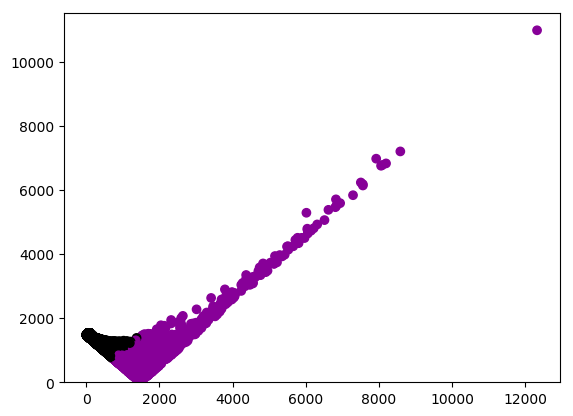

In [24]:
kmeans_x = clf_kmeans_2d[:,0]
kmeans_y = clf_kmeans_2d[:,1]
plt.scatter(kmeans_x, kmeans_y, c=[matplotlib.cm.spectral(float(i) /10) for i in clf_KMeans.labels_]);   
plt.show()

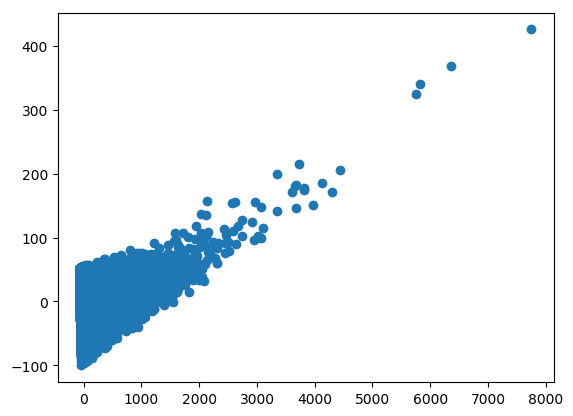

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
pca_x = pca_2d[:,0]
pca_y = pca_2d[:,1]
pl.scatter(pca_x, pca_y)
plt.show()


In [26]:
pca_2d

array([[ 33.92853822, -25.88528684],
       [ 39.80125149,  -6.48866791],
       [-58.17826458,  39.67777567],
       ..., 
       [-39.25165406, -24.28903245],
       [-56.51512096,  -4.30125424],
       [-58.73506318,  32.63555052]])

In [27]:
kmeans_predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [28]:
X_copy = X.assign(preds=pd.Series(kmeans_predictions).values)

In [35]:
display(sum(X_copy.is_expert))
display(sum(X_copy.preds))
display(sum(X_copy.is_expert & X_copy.preds))

14370

1547

1403